# Groupe 11 - TP 2 - Raport

Membres du groupe:
- Oussama Khaloui --- khao1201
- Matthieu Tailleur --- taim1201
- Caroline Wang --- wanc1101

## 1 - Analyse des données

### 1.a - Réduction des données

In [40]:
# Importation des librairies basiques
import pandas as pd
import numpy as np

# Paramètres d'affichage des DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# librairies de visualisation
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

# Librairie sklearn
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Retirer les Warnings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)


# Modèle gaussien
from matplotlib import patches
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

#### Chargement des données

In [41]:
data_file_1 = "./donnees/orders_distance_stores_softmax.csv"
data_file_2 = "./donnees/order_products__prior_specials.csv"
data_orders_distance = pd.read_csv(data_file_1)
data_orders_products = pd.read_csv(data_file_2)

# Vérification du bon chargement des données et comparaison avec ce qui est attendu d'après l'énoncé
print(f"Le dataset orders_distance_stores_softmax contient {data_orders_distance.shape[0]} points et {data_orders_distance.shape[1]} attributs")
print(f"Le dataset order_products__prior_specials contient {data_orders_products.shape[0]} points et {data_orders_products.shape[1]} attributs")

Le dataset orders_distance_stores_softmax contient 136026 points et 10 attributs
Le dataset order_products__prior_specials contient 1172312 points et 6 attributs


Les datasets contiennent tous deux le nombre d'attributs attendu et beaucoup de lignes. L'objectif de cette partie sera de réduire leurs nombre - pour rendre nos algorithmes plus efficaces - tout en conservant le maximum d'information du dataset afin d'effectuer les meilleurs prédictions possibles.

#### Auscultation des données

On commence par visualiser quelques données pour nous faire une idée des datasets

In [42]:
# Obseravtion de quelques données
data_orders_distance.head()

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.304404,1438665,prior,9,1,18,3.0
1,1,210,0,2.304404,2850206,prior,36,0,7,2.0
2,2,210,0,2.304404,2406913,prior,42,0,8,3.0
3,3,210,0,2.304404,1155933,prior,43,2,23,2.0
4,4,210,0,2.304404,271697,prior,56,5,17,3.0


In [43]:
data_orders_distance.tail()

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
136021,136021,206105,9,2.140636,1841888,prior,39,0,21,1.0
136022,136022,206105,9,2.140636,1137676,prior,43,4,15,1.0
136023,136023,206105,9,2.140636,1439511,prior,45,6,9,1.0
136024,136024,206105,9,2.140636,1783607,prior,58,4,19,0.0
136025,136025,206105,9,2.140636,1410956,prior,65,2,9,1.0


on constate la présence de de données catégoriques. on choisit d'encoder les valeurs de la colonne 'eval_set'

In [44]:
data_orders_distance['eval_set'].unique()

array(['prior'], dtype=object)

In [45]:
df_encoded = pd.get_dummies(data_orders_distance, columns=['eval_set'])
data_orders_distance['eval_set'] = df_encoded[['eval_set_prior']]

In [46]:
# Vérification
data_orders_distance

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.304404,1438665,True,9,1,18,3.0
1,1,210,0,2.304404,2850206,True,36,0,7,2.0
2,2,210,0,2.304404,2406913,True,42,0,8,3.0
3,3,210,0,2.304404,1155933,True,43,2,23,2.0
4,4,210,0,2.304404,271697,True,56,5,17,3.0
...,...,...,...,...,...,...,...,...,...,...
136021,136021,206105,9,2.140636,1841888,True,39,0,21,1.0
136022,136022,206105,9,2.140636,1137676,True,43,4,15,1.0
136023,136023,206105,9,2.140636,1439511,True,45,6,9,1.0
136024,136024,206105,9,2.140636,1783607,True,58,4,19,0.0


In [47]:
data_orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
0,0,15,19660,1,1,15
1,1,15,21195,2,1,0
2,2,15,7461,3,1,50
3,3,15,2996,4,1,0
4,4,15,32463,5,1,0


In [48]:
data_orders_products.tail()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
1172307,1172307,3421069,21137,8,1,0
1172308,1172308,3421069,30391,9,1,15
1172309,1172309,3421069,18656,10,1,0
1172310,1172310,3421069,26940,11,1,15
1172311,1172311,3421069,19057,12,1,0


In [49]:
# Suppresion de la colonne Unnamed: 0 dans les datasets (duplicat du numéro de la ligne)
data_orders_distance.drop(columns=['Unnamed: 0'],inplace=True)
data_orders_products.drop(columns=['Unnamed: 0'],inplace=True)

On affiche quelques informations caractérisant les données afin de mieux les appréhender.
Nous réutiliserons ces informations par la suite car elles sont caractéristiques des distributions des données. Nous chercherons donc à les retrouver après avoir réduit le nombre de lignes. 

In [50]:
data_orders_distance.describe()

,user_id,store_id,distance,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,136026.000000,136026.000000,136026.000000,1.360260e+05,136026.000000,136026.000000,136026.000000,134652.000000
mean,101827.940320,4.503374,1.253315,1.713599e+06,50.000000,2.884419,13.036853,2.848097
std,60550.815551,2.866815,0.656473,9.868517e+05,28.577485,1.887552,4.233527,2.537760
min,210.000000,0.000000,0.002863,1.500000e+01,1.000000,0.000000,0.000000,0.000000
25%,49210.000000,2.000000,0.764297,8.590620e+05,25.000000,1.000000,10.000000,1.000000
50%,100229.000000,5.000000,1.173100,1.718160e+06,50.000000,3.000000,13.000000,2.000000
75%,154378.000000,7.000000,1.656305,2.565938e+06,75.000000,4.000000,16.000000,4.000000
max,206105.000000,9.000000,4.843817,3.421069e+06,99.000000,6.000000,23.000000,30.000000


In [51]:
data_orders_products.describe()

,order_id,product_id,add_to_cart_order,reordered,special
count,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06
mean,1.710806e+06,2.558317e+04,7.311208e+00,7.744346e-01,9.745972e+00
std,9.865049e+05,1.403693e+04,6.661885e+00,4.179543e-01,1.497054e+01
min,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.571920e+05,1.357500e+04,3.000000e+00,1.000000e+00,0.000000e+00
50%,1.713000e+06,2.514600e+04,5.000000e+00,1.000000e+00,0.000000e+00
75%,2.563004e+06,3.801600e+04,1.000000e+01,1.000000e+00,1.500000e+01
max,3.421069e+06,4.968300e+04,9.800000e+01,1.000000e+00,5.000000e+01


In [52]:
# Compte des types d'attributs
data_orders_distance.dtypes.value_counts()

int64      6
float64    2
bool       1
Name: count, dtype: int64

In [53]:
data_orders_products.dtypes.value_counts()

int64    5
Name: count, dtype: int64

#### Nettoyage des données

##### Valeurs manquantes

On commence par regarder du côté des valeurs manquantes en regardant le pourcentage de valeurs manquantes dans pour chaque colonnes des datasets

In [54]:
print(f" Table des valeurs manquantes dans le dataset order_distance_stores_softmax\n{data_orders_distance.isnull().mean() * 100}")
print("\n")
print(f"Table des valeurs manquantes dans le dataset order_products_prior_specials\n{data_orders_products.isnull().mean() * 100}")

 Table des valeurs manquantes dans le dataset order_distance_stores_softmax
user_id                   0.000000
store_id                  0.000000
distance                  0.000000
order_id                  0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    1.010101
dtype: float64


Table des valeurs manquantes dans le dataset order_products_prior_specials
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
special              0.0
dtype: float64


Il manque environ 1% de valeurs dans le dataset order_distance_stores_softmax pour la colonne 'days_since_prior_order' indiquant le nombre de jours écoulés depuis le dernier achat.
Il est indiqué dans l'énoncé que ces valeurs manquantes correspondent en réalité au nombre 1.
on remplace donc chaque valeurs manquante par 1.

In [55]:
data_orders_distance['days_since_prior_order'].fillna(1,inplace=True)

C:\Users\carol\AppData\Local\Temp\ipykernel_6388\2124324277.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_orders_distance['days_since_prior_order'].fillna(1,inplace=True)


In [56]:
# Vérification
print(f"Nombre de données NULL : {data_orders_distance['days_since_prior_order'].isnull().sum()}")

Nombre de données NULL : 0


##### Valeurs dupliquées

In [57]:
duplicates_df_products = data_orders_products[data_orders_products.duplicated()]
duplicates_df_products_sorted = duplicates_df_products.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans les données order_products_prior_specials \n{duplicates_df_products_sorted.sum()}")

duplicates_df_distance = data_orders_distance[data_orders_distance.duplicated()]
duplicates_df_distance_sorted = duplicates_df_distance.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans les données order_distance_stores_softmax \n{duplicates_df_distance_sorted.sum()}")

Nombre de valeurs dupliquées dans les données order_products_prior_specials 
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
special              0
dtype: int64
Nombre de valeurs dupliquées dans les données order_distance_stores_softmax 
user_id                   0.0
store_id                  0.0
distance                  0.0
order_id                  0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64


Il n'y a pas de lignes dupliquées dans les données.

##### Gestion des outliers

On commence par visualiser les colonnes pour lesquelles les outliers sont nombreux à l'aide de boxplots.

Boxplots des colonnes du dataset order_distance_stores_softmax


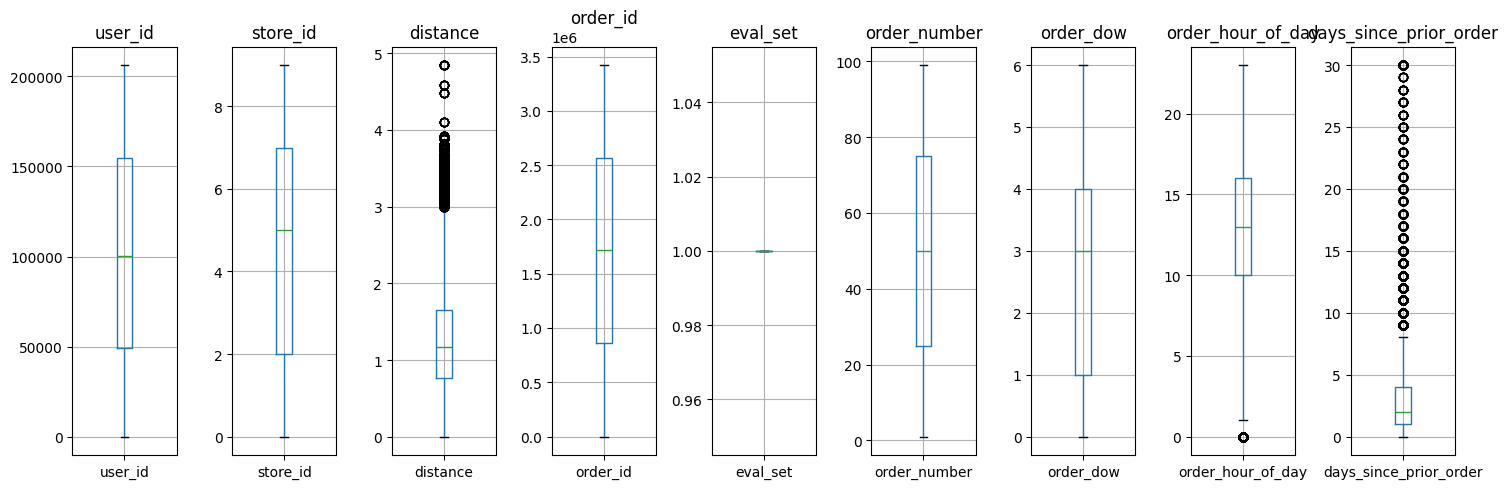

In [58]:
def detect_susceptible_outlier(data) : 
    fig, axes = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(15, 5))
    for i, col in enumerate(data.columns):
        data.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

print("Boxplots des colonnes du dataset order_distance_stores_softmax")
detect_susceptible_outlier(data_orders_distance)

Boxplots des colonnes du dataset order_products_prior_specials


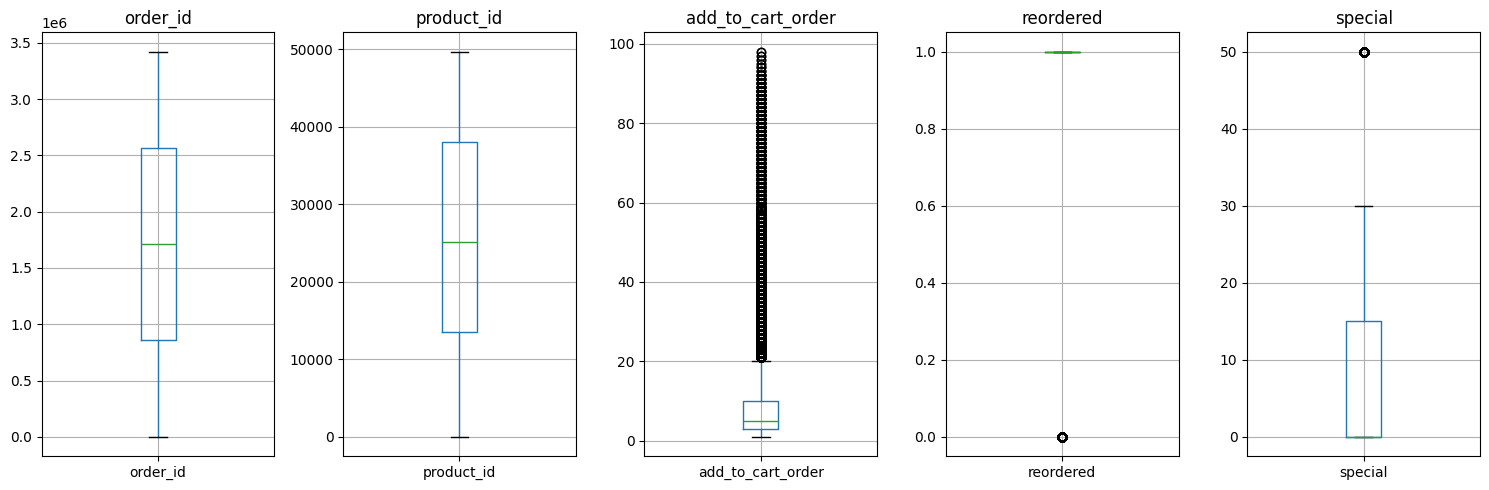

In [59]:
print("Boxplots des colonnes du dataset order_products_prior_specials")
detect_susceptible_outlier(data_orders_products)

Les attributs susceptibles d'avoir des outliers pour les données 'order_distance_stores_softmax' sont :
    + distance
    + order_hour_of_day
    + days_since_prior_order
Les attributs susceptibles d'avoir des outliers pour les données 'order_products_prior_specials' sont :
    + add_to_cart_order
    + special

Ces outliers peuvent toutefois encoder des informations importantes concernant le comportement des clients. Comme ils sont peu nombreux, nous choississons pour l'instant de les conserver dans le dataset et travaillerons dessus si les algorithmes le necessitent dans la suite

#### Intégration des données

##### Combinaison des datasets
On fusionne les datasets selon les id des commandes

In [60]:
data_orders = pd.merge(data_orders_products, data_orders_distance, on='order_id', how='inner')

In [61]:
# Vérification simple
data_orders.head()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,15,19660,1,1,15,54901,1,0.304608,True,51,3,11,2.0
1,15,21195,2,1,0,54901,1,0.304608,True,51,3,11,2.0
2,15,7461,3,1,50,54901,1,0.304608,True,51,3,11,2.0
3,15,2996,4,1,0,54901,1,0.304608,True,51,3,11,2.0
4,15,32463,5,1,0,54901,1,0.304608,True,51,3,11,2.0


#### Réduction

##### Etude des redondances


In [62]:
for col in data_orders.columns :
    print(data_orders[col].value_counts())

order_id
3279252    98
1959075    98
1758550    94
2467301    92
82167      92
           ..
2278182     1
1460941     1
2913673     1
1460722     1
961072      1
Name: count, Length: 136026, dtype: int64
product_id
13176    17652
24852    16466
21137    13163
47209    10654
21903     9594
         ...  
34883        1
38543        1
41120        1
43801        1
17633        1
Name: count, Length: 24860, dtype: int64
add_to_cart_order
1     136026
2     129477
3     120596
4     109843
5      97716
6      85403
7      73526
8      62633
9      53008
10     44945
11     38203
12     32387
13     27628
14     23469
15     19991
16     17050
17     14482
18     12259
19     10441
20      8911
21      7590
22      6466
23      5491
24      4666
25      3979
26      3397
27      2904
28      2491
29      2137
30      1855
31      1620
32      1379
33      1210
34      1044
35       912
36       795
37       691
38       614
39       539
40       482
41       428
42       378
43       340
4

on constate que la colonne 'eval_set' possède les mêmes valeur spour chaque ligne. on choisit donc de supprimer cette colonne car elle n'apporte aucune information dans nos données

In [63]:
data_orders.drop(columns=['eval_set'],inplace=True)

##### Feature engineering rapide
Bien que cela ne soit pas demandé explicitemment dans le sujet du tp, nous regardons rapidement la corrélation 2 à 2 entre les différents attributs des données afin de pouvoir éliminer d'éventuelles redondances dans ces dernière au cas où nous ayons besoin d'accélerer l'entraîenment de nos algorithmes dans la suite.

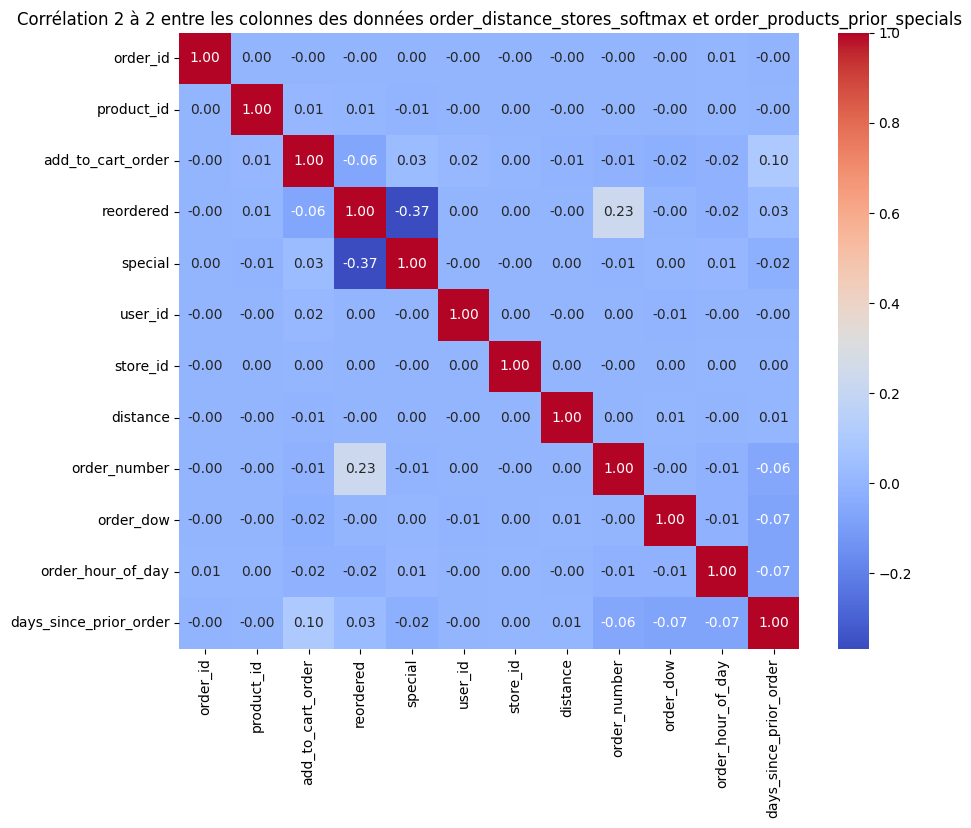

In [64]:
# Corrélation 2 à 2 pour les données order_distance_stores_softmax
correlation_matrix_orders = data_orders.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_orders, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Corrélation 2 à 2 entre les colonnes des données order_distance_stores_softmax et order_products_prior_specials')
plt.show()

Les attributs sont très peu corrélés ou non corrélés. On gardes toutes les features pour le moment mais nous n'écartons pas la possibilité de recourir à des techniques de reduction de dimensionalité si l'entraînement des algortihmes le nécessite dans la suite.

##### Réduction des données
Nous cherchons à présent à réduire le volume de données tout en conservant le maximum d'information ainsi que des données représentatives du dataset initial.

Pour cela, nous procédons à un échantillonage probabiliste **stratifié** de nos données.
Le caractère probabiliste de l'échantillonage assure de réduire le biais lié à la selection effectuée. L'aspect stratifié assure quant à lui d'obtenir un sous-ensemble de données **représentatif de la population originelle**

In [65]:
# On stratify selon l'attribut 'reordered' qui correspond à notre cible.
from sklearn.model_selection import train_test_split

# Assuming 'target' is the column representing classes/groups
_, sampled_df = train_test_split(data_orders, test_size=0.05, stratify=data_orders['reordered'], random_state=42)

# On visualise les statistiques des données obtenues
sampled_stats = sampled_df.describe()
print(sampled_stats.columns.values)

['order_id' 'product_id' 'add_to_cart_order' 'reordered' 'special'
 'user_id' 'store_id' 'distance' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [66]:
# Visualisation des statistiques sur les données avant sampling
data_orders.describe()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06
mean,1.710806e+06,2.558317e+04,7.311208e+00,7.744346e-01,9.745972e+00,1.011486e+05,4.497209e+00,1.252174e+00,4.950891e+01,2.849628e+00,1.298660e+01,3.124883e+00
std,9.865049e+05,1.403693e+04,6.661885e+00,4.179543e-01,1.497054e+01,6.052976e+04,2.858121e+00,6.571061e-01,2.906399e+01,1.920069e+00,4.249346e+00,2.724217e+00
min,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.100000e+02,0.000000e+00,2.863073e-03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.571920e+05,1.357500e+04,3.000000e+00,1.000000e+00,0.000000e+00,4.918600e+04,2.000000e+00,7.640387e-01,2.400000e+01,1.000000e+00,1.000000e+01,1.000000e+00
50%,1.713000e+06,2.514600e+04,5.000000e+00,1.000000e+00,0.000000e+00,9.935200e+04,4.000000e+00,1.171076e+00,4.900000e+01,3.000000e+00,1.300000e+01,3.000000e+00
75%,2.563004e+06,3.801600e+04,1.000000e+01,1.000000e+00,1.500000e+01,1.545560e+05,7.000000e+00,1.654696e+00,7.500000e+01,5.000000e+00,1.600000e+01,4.000000e+00
max,3.421069e+06,4.968300e+04,9.800000e+01,1.000000e+00,5.000000e+01,2.061050e+05,9.000000e+00,4.843817e+00,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


on compare les statistiques avant et après sampling pour voir si la diversité des données est aussi bien représentée qu'avant.

In [67]:
diff_tab = []
for col_name in sampled_df.describe().columns.values:
    stat_pre_sampling = data_orders.describe()[col_name]
    stat_post_sampling = sampled_df.describe()[col_name]
    diff = 100 * abs(stat_post_sampling - stat_pre_sampling) / (stat_post_sampling + stat_pre_sampling)
    diff_tab.append(diff)
print(diff_tab)

[count    90.476129
mean      0.048462
std       0.156523
min      72.727273
25%       0.010588
50%       0.155653
75%       0.215293
max       0.001257
Name: order_id, dtype: float64, count    90.476129
mean      0.028282
std       0.167641
min       0.000000
25%       0.436520
50%       0.015910
75%       0.187726
max       0.000000
Name: product_id, dtype: float64, count    90.476129
mean      0.343111
std       0.141904
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: add_to_cart_order, dtype: float64, count    90.476129
mean      0.000286
std       0.000753
min            NaN
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: reordered, dtype: float64, count    90.476129
mean      0.216205
std       0.014235
min            NaN
25%            NaN
50%            NaN
75%       0.000000
max       0.000000
Name: special, dtype: float64, count    90.476129
mean      0.199873
std       0.016750
min       0

on constate que les statistiques des distributions ont majoritairement été conservé après l'échantillonage. Cela infique que l'information et la représentativité des données a bien été conservée.

In [68]:
# sampled_df.to_csv('reduced_data.csv') Marche aps

### 1.b - Préparation des données

#### Création des ensembles d'entraînement et de test
On sépare les données en ensembles d'entraînement et de test tout en conservant la diversité des données dans chacun de ces ensembles. pour cela, on utilise l'option 'stratfied' de la fonction train_test_split de sklearn

In [69]:
X = data_orders.drop(columns=['reordered']) # datas
y = data_orders['reordered'] # targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#### Transformation

##### Normalisation des ensmebles d'entraîenemnt et de test
Les algorithmes que nous appliquerons par la suite (CNN et SVM) ne nécessitent pas de connaître la distribution des données.
Nous procédons donc à la normalisation des données afin de les ramener dans un intervalle connu.

In [70]:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.fit_transform(X_test)

X_train = X_train_scaled
X_test = X_test_scaled

In [71]:
# Vérification
print(f"Moyenne de X_train_scaled = {X_train_scaled.mean()} et déviation standard = {X_train_scaled.std()}")
print(f"Moyenne de X_test_scaled = {X_test_scaled.mean()} et déviation standard = {X_test_scaled.std()}")

Moyenne de X_train_scaled = -1.1065636922295917e-16 et déviation standard = 1.0000000000000007
Moyenne de X_test_scaled = 4.673599195311817e-17 et déviation standard = 1.0000000000000002


A l'issu des ces étapes de prétraitement, les données ont été standardisée et peuvent être desormais utilisées dans les algorithmes suivants.

## 2 - Choix du modèle de prédiction

### 2.a - Modèle RNN et score F1

In [37]:
# Diviser l'ensemble d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Vérifier les formes des ensembles créés
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

# Assuming y_train and y_test are your target labels
# Convert them to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_val_one_hot = to_categorical(y_val)

y_train_one_hot

Shape of X_train: (750279, 11)
Shape of X_val: (187570, 11)
Shape of X_test: (234463, 11)


AttributeError: module 'keras.src.backend' has no attribute 'is_tensor'

#### Prédiction de la classe

In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy()
metrics_fn = keras.metrics.BinaryAccuracy()

In [ ]:
# Define a function to create the model based on hyperparameters
def create_model(optimizer='adam', neurons_layer1=64, neurons_layer2=64):
    model = Sequential()    
    model.add(keras.Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons_layer1, activation='relu'))
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics_fn])
    return model

# Wrap the create_model function with KerasClassifier
keras_model = KerasClassifier(model=create_model, neurons_layer1=64, neurons_layer2=64, metrics=[metrics_fn])

# Define the grid of hyperparameters to search
param_grid = {
    'neurons_layer1': [32, 64, 128],
    'neurons_layer2': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop']
}

# Define F1 score as the metric
f1_scorer = make_scorer(f1_score, average='micro')

# Initialize GridSearchCV with F1 score as the metric
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=10, scoring=f1_scorer)
# Perform grid search
grid_result = grid.fit(X_train, y_train_one_hot, epochs=10, batch_size=64, validation_data=(X_val, y_val_one_hot), verbose=1)

Epoch 1/10
10551/10551 [==============================] - 17s 2ms/step - loss: 0.4220 - binary_accuracy: 0.8049 - val_loss: 0.4153 - val_binary_accuracy: 0.8096
Epoch 2/10
10551/10551 [==============================] - 17s 2ms/step - loss: 0.4152 - binary_accuracy: 0.8094 - val_loss: 0.4126 - val_binary_accuracy: 0.8115
Epoch 3/10
10551/10551 [==============================] - 15s 1ms/step - loss: 0.4136 - binary_accuracy: 0.8104 - val_loss: 0.4112 - val_binary_accuracy: 0.8120
Epoch 4/10
10551/10551 [==============================] - 17s 2ms/step - loss: 0.4130 - binary_accuracy: 0.8106 - val_loss: 0.4114 - val_binary_accuracy: 0.8114
Epoch 5/10
10551/10551 [==============================] - 18s 2ms/step - loss: 0.4123 - binary_accuracy: 0.8110 - val_loss: 0.4111 - val_binary_accuracy: 0.8112
Epoch 6/10
10551/10551 [==============================] - 16s 2ms/step - loss: 0.4119 - binary_accuracy: 0.8111 - val_loss: 0.4105 - val_binary_accuracy: 0.8115
Epoch 7/10
10551/10551 [==========

In [ ]:
# Display results
print("- Best parameters found: ", grid_result.best_params_)
print("\n")
print("- Best F1 score found: ", round(grid_result.best_score_,2))

#### Verification sur les données de test

In [ ]:
best_model = grid_result.best_estimator_

# Faire des prédictions sur l'ensemble de test avec le meilleur modèle
y_pred_best = best_model.predict(X_test)

f1_best = f1_score(y_test_one_hot, y_pred_best, average='micro')

# Afficher les résultats pour le meilleur modèle
print("Best model performance:")
print("F1 Score:", round(f1_best,3))

### 2.b - Modèle SVM et score F1

On écrit une fonction qui permettra de chercher les hyperparamètres du modèle, en fonction du type de noyau choisi.

In [72]:
# Recherche d'hyperpatamètres en fonction du noyau
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

def hyper_parameters_search(model, kernel, X_train, y_train):
        if kernel == 'linear':
            C_range = [1,10,100,1000]
            param_grid = dict(C=C_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau RBF : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        elif kernel == 'rbf':
            C_range = [1,10,100,1000]
            gamma_range = [1,0.1,0.001,0.0001]
            param_grid = dict(gamma=gamma_range, C=C_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau RBF : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        elif kernel == 'sigmoid':
            coef0_range = [-5, -3, -1, -0.1, 0.0, 0.1, 1]
            param_grid = dict(coef0=coef0_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau sigmoïde : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        elif kernel == 'poly':
            coef0_range = [-5, -3, -1, -0.1, 0.0, 0.1, 1]
            degree_range = [2, 3, 4, 5, 6, 7]
            param_grid = dict(coef0=coef0_range, degree = degree_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau polynomial : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        print("Erreur recherche hyper-paramètres")
        return model     

Pour chaque type de noyau, on entraine un modèle correspondant pour ensuite l'évaluer et chercher ses hyperparamètres. On enregistre ensuite ces données dans un fichier, à partir duquel on pourra récupérer le modèle entrainé

In [73]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
import joblib

kernel_values = ['linear', 'rbf', 'sigmoid', 'poly']
for kernel in kernel_values :
    print(f'----- Modèle de noyau {kernel} -----')
    
    svm_model = SVC(kernel=kernel)
    svm_model.fit(X_train_scaled, y_train)
    y_pred = svm_model.predict(X_test_scaled)
    
    # Évaluation du modèle    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'Matrice de confusion :')
    print(conf_matrix)
    
    f1_svm = f1_score(y_test, y_pred)
    print(f'Score F1 : {f1_svm}')
    
    # Recherche des hyperparamètres
    best_svm_model, best_svm_param = hyper_parameters_search(svm_model, kernel, X_train=X_train_scaled, y_train=y_train)
    best_svm_model.fit(X_train_scaled, y_train)
    best_y_pred = best_svm_model.predict(X_test_scaled)

    # Évaluation du meilleur
    best_conf_matrix = confusion_matrix(y_test, best_y_pred)
    print(f'Matrice de confusion')
    print(best_conf_matrix)
    
    best_f1_svm = f1_score(y_test, best_y_pred)
    print(f'Score F1 : {best_f1_svm}')
    
    # Sauvegarde du modèle et des hyperparamètres dans un fichier
    joblib.dump(best_svm_model, f'modele_svm_{kernel}.pkl')
    joblib.dump(best_svm_param, f'hyperparametres_svm_{kernel}.pkl')

----- Modèle de noyau linear -----


On récupère les données précédemment enregistrées.

In [ ]:
# Chargement des modèle et des hyperparamètres à partir des fichiers sauvegardés
kernel_values = ['linear', 'rbf', 'sigmoid', 'poly']
for kernel in kernel_values :
    modele_svm = joblib.load(f'modele_svm_{kernel}.pkl')
    hyperparametres_svm = joblib.load(f'hyperparametres_svm_{kernel}.pkl')
    print(f'Meilleurs paramètres du modèle SVM avec noyau de type {kernel} : {hyperparametres_svm}')

## 3 - Conclusion

### 3.a -



### 3.b -

Les hyperparamètres utilisés pour le modèle SVM sont les suivants :

- Pour le noyau linear :
    - C : la valeur de pénalité du terme d'erreur.

- Pour le noyau rbf :
    - C : la valeur de pénalité du terme d'erreur.
    - gamma : la valeur du coefficient du noyau RBF.

- Pour le noyau sigmoid :
    - coef0 : la valeur de l'ordonnée à l'origine dans le noyau sigmoïde.

- Pour le noyau poly :
    - coef0 : la valeur de l'ordonnée à l'origine dans le noyau polynomial.
    - degree : la valeur du degré du noyau polynomial.

### 3.c -

### 3.d -

Le score F1 est très bon, il est proche de 1. Cela signifie que le modèle a bien été entrainé et que ses capacités de prédiction sont satisfaisantes.